#### Data preparation

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [3]:
# import data:
with open('Data/samurai_names.txt', 'r') as d:
    nams = d.read().lower()#.splitlines()

In [4]:
names = [' '.join(n.lower().split(" ")) + "\n" for n in nams.splitlines()]
names, len(names)

(['abe juro\n',
  'abe katsuyoshi\n',
  'abe masaatsu\n',
  'abe masahiro\n',
  'abe masakatsu\n',
  'abe masaoki\n',
  'abe masasuke\n',
  'abe masataka\n',
  'abe masatomo\n',
  'abe masatsugu\n',
  'abe masayoshi\n',
  'abe no sadato\n',
  'abe no yoritoki\n',
  'abiru eisaburo\n',
  'adachi tokiaki\n',
  'adachi yasumori\n',
  'aisu hisatada\n',
  'aiura nagato\n',
  'akagawa motoyasu\n',
  'akai naomasa\n',
  'akai terukage\n',
  'akaike nagato\n',
  'akamatsu masanori\n',
  'akamatsu mitsusuke\n',
  'akamatsu norifusa\n',
  'akamatsu yoshisuke\n',
  'akashi motojiro\n',
  'akashi teruzumi\n',
  'akaza naoyasu\n',
  'akaza shichiroemon\n',
  'akazawa tomotsune\n',
  'akazawa tsuneyasu\n',
  'akechi hidemitsu\n',
  'akechi mitsuhide\n',
  'akechi mitsukuni\n',
  'akechi mitsutada\n',
  'akechi mitsuyasu\n',
  'akimoto takatomo\n',
  'akita sanesue\n',
  'akiyama nobutomo\n',
  'akizuki fumitane\n',
  'akizuki tanenaga\n',
  'akizuki taneshige\n',
  'akizuki tanezane\n',
  'amaji is

In [5]:
# hiragana tokenizer:
from pykakasi import kakasi
kakasi = kakasi()
hiragana_chars = [
    "あ", "い", "う", "え", "お",
    "か", "き", "く", "け", "こ",
    "さ", "し", "す", "せ", "そ",
    "た", "ち", "つ", "て", "と",
    "な", "に", "ぬ", "ね", "の",
    "は", "ひ", "ふ", "へ", "ほ",
    "ま", "み", "む", "め", "も",
    "や", "ゆ", "よ",
    "ら", "り", "る", "れ", "ろ",
    "わ", "を", "ん",
    "が", "ぎ", "ぐ", "げ", "ご",
    "ざ", "じ", "ず", "ぜ", "ぞ",
    "だ", "ぢ", "づ", "で", "ど",
    "ば", "び", "ぶ", "べ", "ぼ",
    "ぱ", "ぴ", "ぷ", "ぺ", "ぽ",
    "きゃ", "きゅ", "きょ",
    "しゃ", "しゅ", "しょ",
    "ちゃ", "ちゅ", "ちょ",
    "にゃ", "にゅ", "にょ",
    "ひゃ", "ひゅ", "ひょ",
    "みゃ", "みゅ", "みょ",
    "りゃ", "りゅ", "りょ",
    "ぎゃ", "ぎゅ", "ぎょ",
    "じゃ", "じゅ", "じょ",
    "びゃ", "びゅ", "びょ",
    "ぴゃ", "ぴゅ", "ぴょ",
    "ん",
]

In [6]:
tokens = [kakasi.convert(h)[0]['hepburn'] for h in hiragana_chars]
tokens.insert(0, " ")
tokens.insert(0, "\n")
max_token_length = max(len(t) for t in tokens)
tokens, max_token_length

(['\n',
  ' ',
  'a',
  'i',
  'u',
  'e',
  'o',
  'ka',
  'ki',
  'ku',
  'ke',
  'ko',
  'sa',
  'shi',
  'su',
  'se',
  'so',
  'ta',
  'chi',
  'tsu',
  'te',
  'to',
  'na',
  'ni',
  'nu',
  'ne',
  'no',
  'ha',
  'hi',
  'fu',
  'he',
  'ho',
  'ma',
  'mi',
  'mu',
  'me',
  'mo',
  'ya',
  'yu',
  'yo',
  'ra',
  'ri',
  'ru',
  're',
  'ro',
  'wa',
  'wo',
  'n',
  'ga',
  'gi',
  'gu',
  'ge',
  'go',
  'za',
  'ji',
  'zu',
  'ze',
  'zo',
  'da',
  'ji',
  'zu',
  'de',
  'do',
  'ba',
  'bi',
  'bu',
  'be',
  'bo',
  'pa',
  'pi',
  'pu',
  'pe',
  'po',
  'kya',
  'kyu',
  'kyo',
  'sha',
  'shu',
  'sho',
  'cha',
  'chu',
  'cho',
  'nya',
  'nyu',
  'nyo',
  'hya',
  'hyu',
  'hyo',
  'mya',
  'myu',
  'myo',
  'rya',
  'ryu',
  'ryo',
  'gya',
  'gyu',
  'gyo',
  'ja',
  'ju',
  'jo',
  'bya',
  'byu',
  'byo',
  'pya',
  'pyu',
  'pyo',
  'n'],
 3)

In [7]:
# creating lookup tables, encode & decode:
class Encoder:
    def __init__(self, toks):
        self.tokens = toks
        self.max_token_length = max(len(t) for t in self.tokens)
        self.stoi = {s:i for i, s in enumerate(self.tokens)}
        self.itos = {i:s for s,i in self.stoi.items()}
    
    def __call__(self, word):
        word_tokenized = []
        window = ""
        for ch in word:
            window += ch
            if window in self.tokens:
                word_tokenized.append(self.stoi[window])
                window = ""
            if len(window) > self.max_token_length:
                print(f"Failed to tokenize: {word}, window: {window}")
                window = ""
                return []
       
        return word_tokenized

    def decode(self, toks, joined=True):
        word = []
        for t in toks:
            word.append(self.itos[t]) 
        return ''.join(word) if joined else word

In [8]:
encoder = Encoder(tokens)
encoded = []
num = 0
for n in names:
    enc = encoder(n)
    if len(enc) != 0:
        num += 1
    encoded += enc
print(f'Number of successfully encoded names: {num}')

Failed to tokenize: amaji issen
, window: ssen
Failed to tokenize: beppu kagenaga
, window: ppu 
Failed to tokenize: bessho harusada
, window: ssho
Failed to tokenize: bessho nagaharu
, window: ssho
Failed to tokenize: bessho toyoharu
, window: ssho
Failed to tokenize: giuseppe chiara
, window: ppe 
Failed to tokenize: hattori hanzaburo
, window: ttor
Failed to tokenize: hattori hanzo
, window: ttor
Failed to tokenize: hattori masanari
, window: ttor
Failed to tokenize: hattori takeo
, window: ttor
Failed to tokenize: hayashi jussai
, window: ssai
Failed to tokenize: honma family
, window: fami
Failed to tokenize: hosokawa gracia
, window: grac
Failed to tokenize: hotta masamori
, window: tta 
Failed to tokenize: hotta masanaka
, window: tta 
Failed to tokenize: hotta masanari
, window: tta 
Failed to tokenize: hotta masasuke
, window: tta 
Failed to tokenize: hotta masataka
, window: tta 
Failed to tokenize: hotta masatomo
, window: tta 
Failed to tokenize: hotta masatora
, window: tt

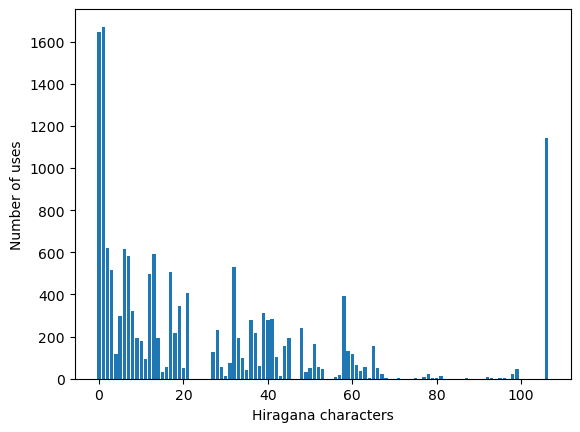

In [9]:
# token frequencies:
freqs = torch.zeros(len(tokens), dtype=torch.long)
for e in encoded:
    freqs[e].data +=1 
plt.bar(torch.arange(0,len(freqs), 1), freqs)
plt.xlabel("Hiragana characters")
plt.ylabel("Number of uses")
plt.show()

In [10]:
exname = "Abe no Sadato".lower()
encoder.decode(encoder(exname), joined=False)

['a', 'be', ' ', 'n', 'o', ' ', 'sa', 'da', 'to']

In [11]:
# filter out zero entries:
zero_places = []
for i, f in enumerate(freqs):
    if f == 0:
        print(f"Unused token: {tokens[i]}")
        zero_places.append(i)

Unused token: na
Unused token: ni
Unused token: nu
Unused token: ne
Unused token: no
Unused token: wo
Unused token: n
Unused token: ji
Unused token: zu
Unused token: pi
Unused token: kya
Unused token: sha
Unused token: nya
Unused token: nyu
Unused token: nyo
Unused token: hya
Unused token: hyu
Unused token: mya
Unused token: myu
Unused token: myo
Unused token: rya
Unused token: gya
Unused token: ja
Unused token: bya
Unused token: byu
Unused token: byo
Unused token: pya
Unused token: pyu
Unused token: pyo


In [12]:
# modify the token table to discard unused ones:
modified_tokens = [tokens[i] for i in range(len(tokens)) if i not in zero_places]

In [13]:
# re-encode the names:
rencoder = Encoder(modified_tokens)
rencoded = []
num = 0
for n in names:
    enc = rencoder(n)
    if len(enc) != 0:
        num += 1
    rencoded += enc
print(f'Number of successfully encoded names: {num}')


Failed to tokenize: amaji issen
, window: ssen
Failed to tokenize: beppu kagenaga
, window: ppu 
Failed to tokenize: bessho harusada
, window: ssho
Failed to tokenize: bessho nagaharu
, window: ssho
Failed to tokenize: bessho toyoharu
, window: ssho
Failed to tokenize: giuseppe chiara
, window: ppe 
Failed to tokenize: hattori hanzaburo
, window: ttor
Failed to tokenize: hattori hanzo
, window: ttor
Failed to tokenize: hattori masanari
, window: ttor
Failed to tokenize: hattori takeo
, window: ttor
Failed to tokenize: hayashi jussai
, window: ssai
Failed to tokenize: honma family
, window: fami
Failed to tokenize: hosokawa gracia
, window: grac
Failed to tokenize: hotta masamori
, window: tta 
Failed to tokenize: hotta masanaka
, window: tta 
Failed to tokenize: hotta masanari
, window: tta 
Failed to tokenize: hotta masasuke
, window: tta 
Failed to tokenize: hotta masataka
, window: tta 
Failed to tokenize: hotta masatomo
, window: tta 
Failed to tokenize: hotta masatora
, window: tt

In [14]:
max(rencoded)

77

#### Tokenizer

In [15]:
# metaparameters & constants:
vocab_size = len(modified_tokens) # how many tokens are used
block_size = 5 # how many previous characters we consider
n_emb = 32 # embedding dimension
n_heads = 4 # how many attention heads to use
head_size = n_emb // n_heads # size of the self-attention head (it's n_emb // n_heads, because we concatanate over the multiple attention heads)

batch_size = 8 # how many data to be processed in a paralell manner

dropout_rate = 0.1 # probability of zeroing entries

trainrate = 0.9 # ratio of the training data

In [16]:
#create and split data:
import random
random.shuffle(names)
rencoded = []
num = 0
for n in names:
    enc = rencoder(n)
    if len(enc) != 0:
        num += 1
    rencoded += enc
print(f'Number of successfully encoded names: {num}')

data = torch.tensor(rencoded, dtype=torch.long)

# split up data:
n1 = int(len(data) * trainrate)

train_data = data[:n1]
val_data = data[n1:]

Failed to tokenize: sassa magosuke
, window: ssa 
Failed to tokenize: hayashi jussai
, window: ssai
Failed to tokenize: isshiki yoshimichi
, window: sshi
Failed to tokenize: giuseppe chiara
, window: ppe 
Failed to tokenize: yamaoka tesshu
, window: sshu
Failed to tokenize: hattori takeo
, window: ttor
Failed to tokenize: takeda shingen's 24 generals
, window: 's 2
Failed to tokenize: taigen sessai
, window: ssai
Failed to tokenize: hotta masamori
, window: tta 
Failed to tokenize: kikkawa okitsune
, window: kkaw
Failed to tokenize: rokkaku yoshikata
, window: kkak
Failed to tokenize: hotta masasuke
, window: tta 
Failed to tokenize: hotta masayoshi
, window: tta 
Failed to tokenize: william adams
, window: will
Failed to tokenize: kikkawa tsuneie
, window: kkaw
Failed to tokenize: rokkaku yoshiharu
, window: kkak
Failed to tokenize: hattori hanzo
, window: ttor
Failed to tokenize: naito julia
, window: lia

Failed to tokenize: rokkaku sadayori
, window: kkak
Failed to tokenize: hotta 

In [17]:
# construct batches:
def getBatch(data_split):
    dat = train_data if data_split == 'train' else val_data
    # generate the random batch indices:
    ix = torch.randint(0, len(dat) - block_size, (batch_size, ))
    x = torch.stack([dat[i:i+block_size] for i in ix]) # input
    y = torch.stack([dat[i+1:i+block_size+1] for i in ix]) # expected output
    return x, y

In [18]:
print(len(train_data), len(val_data))

14355 1596


##### Embedding

In [19]:
# embedding tables, both positional and token embedding:
emb_token = nn.Embedding(vocab_size, n_emb) # token embedding
emb_pos = nn.Embedding(block_size, n_emb) # positional embedding

# placeholder:
lm_head = nn.Linear(n_emb, vocab_size, bias=False) # to convert back to characters of which range up to vocab_size

In [20]:
# spelled out example forward pass
print(f'Just to remember: vocab size: {vocab_size}, block size: {block_size}, batch size: {batch_size}, embedding dimension: {n_emb}')
x,y  = getBatch('train') # (batch_size, block_size)
x_emb = emb_token(x)
x_pos = emb_pos(torch.arange(0, block_size, dtype=torch.long))
x = x_emb + x_pos # some use dropout layer here, why?
print(x.shape)


Just to remember: vocab size: 78, block size: 5, batch size: 8, embedding dimension: 32
torch.Size([8, 5, 32])


#### Single self-attention head

In [21]:
# key, querry and value layers:
# little reminder:
# key: what information a token has
# querry: what information the token seeks
# value: what information a token is willing to communicate

print(f'Just to remember: batch size: {batch_size}, block size: {block_size},  embedding dimension: {n_emb}, head size: {head_size}')

key = nn.Linear(n_emb, head_size*n_heads, bias=False)
querry = nn.Linear(n_emb, head_size*n_heads, bias=False)
value = nn.Linear(n_emb, head_size*n_heads, bias=False)

k = key(x) # (batch_size, block_size, head_size)
q = querry(x) # (batch_size, block_size, head_size)
v = value(x) # (batch_size, block_size, head_size)
att = q @ k.transpose(1,2) * (1.0 / math.sqrt(k.size(-1))) # (batch_size, block_size, block_size), normalize with head_size not to skew the weight distribution

# causality, only consider past tokens:
tril = torch.tril(torch.ones(block_size, block_size))
att = att.masked_fill(tril == 0, float('-inf')) # -inf because of incoming softmax
att = F.softmax(att, dim=-1) # softmax over the last dim (of size block_size), since want to keep the batches intact
# dropout here?
y = att @ v
# dropout here too? residual?
print(f'in: {x.shape}, out: {y.shape}')

Just to remember: batch size: 8, block size: 5,  embedding dimension: 32, head size: 8
in: torch.Size([8, 5, 32]), out: torch.Size([8, 5, 32])


In [22]:
# note: class inits use global variables fixed above:
class SingleHeadAttention(nn.Module):
    """Single head of self-attention"""

    def __init__(self, head_size):
        super().__init__()

        assert n_emb % head_size == 0 # to ensure the ability to concatanate them later
        self.n_emb = n_emb
        self.n_head = head_size
        # init the linear layers:
        self.key = nn.Linear(n_emb, self.n_head, bias=False)
        self.value = nn.Linear(n_emb, self.n_head, bias=False)
        self.query = nn.Linear(n_emb, self.n_head, bias=False)

        self.register_buffer("causal", torch.ones(block_size, block_size))

        # dropout layer:
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        _, block, nemb = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        att = q @ k.transpose(-2, -1) * (1.0 / math.sqrt(k.size(-1))) 
        # casuality:
        att = att.masked_fill(self.causal[:block, :block] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.dropout(att)
        y = att @ v
        return y

#### Multi headed attention

In [23]:
# multi headed attention spelled out on an example:
heads = [SingleHeadAttention(head_size) for _ in range(n_heads)]
outs = [h(x) for h in heads]
out = torch.cat(outs, dim=-1)
out.shape

torch.Size([8, 5, 32])

In [24]:
class MultiHeadAttention(nn.Module):
    """Multiple single head modules in paralell then concatanate the result"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SingleHeadAttention(head_size) for _ in range(num_heads)])
        # extra linear layer and dropout, why this?
        self.proj = nn.Linear(n_emb, n_emb)
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # concatanate alongside the last dimension
        out = self.dropout(self.proj(out))
        return out

In [28]:
print(f'Just to remember: batch size: {batch_size}, block size: {block_size},  embedding dimension: {n_emb}, head size: {head_size}')
atti = MultiHeadAttention(n_heads, head_size)
y = atti(x)
y.shape

Just to remember: batch size: 8, block size: 5,  embedding dimension: 32, head size: 8


torch.Size([8, 5, 32])

#### Feed forwars layer (MLP) - this is where the computation happens

In [29]:
class FeedForward(nn.Module):

    def __init__(self, n_emb):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(n_emb, 4*n_emb, bias=True), # why 4x? I guess just to have more parameters
            nn.ReLU(),
            nn.Linear(4*n_emb, n_emb), 
            nn.Dropout(dropout_rate),
        )

    def forward(self, x):
        return self.layers(x)

In [30]:
ffwd = FeedForward(n_emb)
y = ffwd(x)
y.shape

torch.Size([8, 5, 32])

#### Complete transformer

In [34]:
# expects a batch of embedded examples:
class Transformer(nn.Module):
    def __init__(self, n_emb, num_heads):
        super().__init__()
        head_size = n_emb // num_heads
        # attention:
        self.att = MultiHeadAttention(num_heads, head_size)
        # feed forward:
        self.ffwd = FeedForward(n_emb)
        # layernorms:
        self.layernorm1 = nn.LayerNorm(n_emb)
        self.layernorm2 = nn.LayerNorm(n_emb)

    def forward(self, x):
        x = x + self.att(self.layernorm1(x)) # residual connection
        x = x + self.ffwd(self.layernorm2(x))
        return x

In [35]:
class NameGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        # embedding:
        self.token_emb = nn.Embedding(vocab_size, n_emb)
        self.pos_emb = nn.Embedding(vocab_size, n_emb)
        self.attn = Transformer(n_emb, n_heads) # add maybe more transformer layers
        self.ln_final = nn.LayerNorm(n_emb)
        self.linear_final = nn.Linear(n_emb, vocab_size)

    def forward(self, inp, target = None): # input is a batch of tokenized examples of size (batch_size, block_size)
        batch, block = inp.shape
        # embedding:
        emb_tok = self.token_emb(inp)
        emb_pos = self.pos_emb(torch.arange(0, block)) 
        x = emb_pos + emb_tok
        # layers:
        x = self.attn(x)
        x = self.ln_final(x)
        logits = self.linear_final(x)
        # loss:
        if target is None:
            loss = None

        else:
            batch, block, vocab = logits.shape
            logits = logits.view(batch * block, vocab)
            target = target.view(batch * block)
            loss = F.cross_entropy(logits, target)

        return logits, loss
    

    def generate(self, curr_context, num_new_tokens):
        """Generates new tokens using the current state of the model and an input context"""
        for _ in range(num_new_tokens):
            # crop the current context to ensure (batch, block) shape, since we'll be adding to it:
            last_context = curr_context[:, -block_size:]
            # propagate throught the model:
            logits, _ = self(last_context)
            # focus only on the last step:
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            # sample the distribution:
            next_context = torch.multinomial(probs, num_samples=1)
            curr_context = torch.cat((curr_context, next_context), dim=1)
        return curr_context    

In [36]:
model = NameGenerator()
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')

Total number of parameters: 20238


In [37]:
# training:
max_iters = 3
learning_rate = 1e-3
# create optimizer:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# track losses:
lossi = []

for i in range(max_iters):
    # construct a batch:
    xb, yb = getBatch('train')

    # evaluate loss:
    _, loss = model(xb, yb)

    # backward and update:
    optimizer.zero_grad(set_to_none=True)
    loss.backward() # backpropagate
    optimizer.step() # update

    

    # track and print stats:
    if i % 100 == 0:
        lossi.append(loss)
        print(f'{i:5d}/{max_iters:5d}: batch loss: {loss:4f}')





    0/    3: batch loss: 4.476283


In [38]:
loss

tensor(4.3372, grad_fn=<NllLossBackward0>)

In [39]:
# generate:
context = torch.zeros((1,1), dtype=torch.long)
print(rencoder.decode(model.generate(context, 100)[0].tolist()))


ryubugedayakobijodowachiarabiregakajumunchaporoatsubohyodechopesogyobezepuyoyachobedauusopogiwachakahoguzege gorakayuyutesujogaechobikoeregyuafuyazayagugibutofuryokukyubadekyojokiburiugowajisachumidapuhyocho


In [33]:
# TODO:
# wrap the above into pytorch classes --> at this point can already be trained and tested - DONE
# implement multi headed attention - DONE
# add an MLP on top (feedforward) - DONE

# wrap everything up into a transformer module (don't forget the residual connection) - DONE
# create the name generator model as yet another wrapper - DONE
# export everything to a python script - DONE
# train, tune and enjoy  :)